##Домашнее задание №2 

Ссылка на репозиторий: \
https://github.com/vecherochek/decision-making-theory

Работа выполнена: 
- **Буреева Полина** (github: vecherochek - https://github.com/vecherochek)
- **Тришин Дмитрий** (github: newmersedez - https://github.com/newmersedez)
- **Ложкина Ольга** (github: JoFNash - https://github.com/JoFNash)

Группа: **М80-411Б-19**

# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [133]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from numpy.typing import ArrayLike
from typing import List, Tuple
from scipy.special import expit

In [134]:
# загрузка и подготовка данных
tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']

start_date = '2020-04-01'
end_date = '2022-04-22'

data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Сохраним данные в .csv файл
data.to_csv('data.csv', index=True, date_format='%d.%m.%Y')  

data

[*********************100%***********************]  6 of 6 completed


,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-01,90.120003,180.059998,51.000000,97.760002,24.754999,184.779999
2020-04-02,90.620003,187.039993,50.599998,99.400002,24.955000,186.949997
2020-04-03,94.419998,189.770004,53.599998,99.099998,24.830000,185.639999
2020-04-06,97.800003,191.100006,54.400002,100.919998,25.754999,190.699997
2020-04-07,98.120003,191.220001,54.599998,98.980003,26.049999,197.630005
...,...,...,...,...,...,...
2022-04-15,77.720001,224.000000,100.099998,398.600006,66.750000,130.880005
2022-04-18,75.599998,216.990005,100.099998,403.149994,64.605003,123.849998
2022-04-19,75.199997,220.720001,99.300003,391.149994,63.200001,120.300003


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

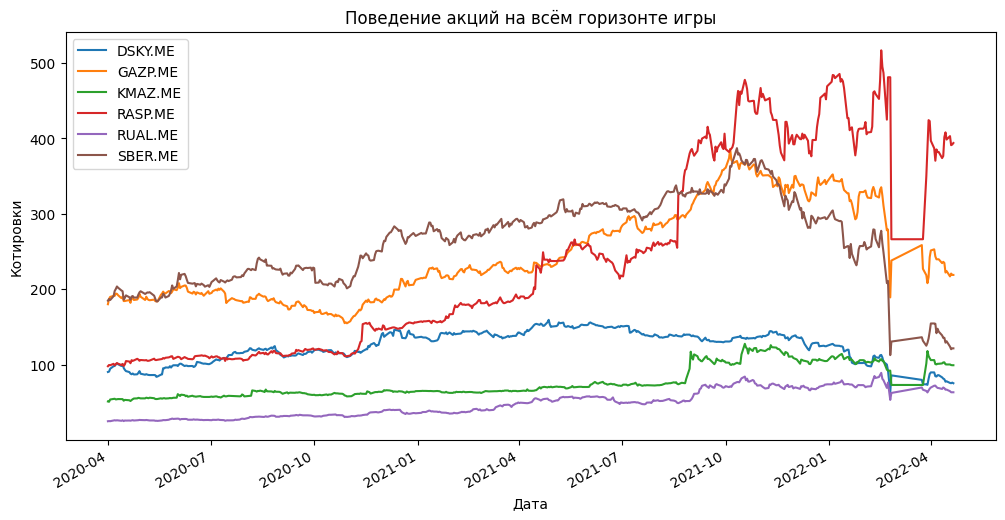

In [135]:
# красивая визуализация на графике с подписями и адекватным масштабом

data.plot(figsize=(12,6))

plt.title('Поведение акций на всём горизонте игры')
plt.xlabel('Дата')
plt.ylabel('Котировки')

plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [136]:
table = []
for t in range(1, len(data.values)):
    x = data.values[t]/data.values[t-1]
    table.append(x)

returns = pd.DataFrame(index = data.index[1:], columns = data.columns, data = table)
# Строим таблицу с ежедневными доходностями каждого тикера
returns

,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-02,1.005548,1.038765,0.992157,1.016776,1.008079,1.011744
2020-04-03,1.041933,1.014596,1.059289,0.996982,0.994991,0.992993
2020-04-06,1.035798,1.007008,1.014925,1.018365,1.037253,1.027257
2020-04-07,1.003272,1.000628,1.003676,0.980777,1.011454,1.036340
2020-04-08,1.019160,1.015113,0.983517,1.017175,0.988484,1.013459
...,...,...,...,...,...,...
2022-04-15,1.006214,1.008509,0.998006,0.976602,1.001500,1.014181
2022-04-18,0.972723,0.968705,1.000000,1.011415,0.967865,0.946287
2022-04-19,0.994709,1.017190,0.992008,0.970234,0.978252,0.971336


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

Градиент функции $f_t(x) = -\log r_t^\top x$ выглядит следующим образом:

$$
\nabla f_t(x) = -\frac{1}{r_t^\top x} r_t.
$$

Градиент функции $f_t(x)$ - это вектор частных производных функции $f_t(x)$ по каждой координате вектора $x$. Явная формула для итерации OGD (Orthogonal Gradient Descent) выглядит следующим образом:

$$x_{t+1} = \Pi_{\mathcal{X}}\left(x_t - \eta_t \nabla f_t(x_t)\right),$$

где $\Pi_{\mathcal{X}}$ - оператор проекции на множество $\mathcal{X}$, $\eta_t$ - длина шага на итерации $t$, $\nabla f_t(x_t)$ - градиент функции $f_t(x)$ в точке $x_t$.


Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [137]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [138]:
def investor(x, r, eta):
    grad = -r / np.dot(r.reshape(1,6), x.T)
    x = simplex_projection(x - eta * grad)
    return x

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

Шаг в методе онлайн-градиентного спуска (OGD) выбирается на основе длины шага, которую определяет инвестор. Длина шага является гиперпараметром алгоритма и влияет на сходимость алгоритма к оптимальному решению. Оптимальное значение шага зависит от характеристик функции, которую минимизирует алгоритм, а также от характеристик шума, вносимого в градиент функции.

Выбор шага является компромиссом между скоростью сходимости и устойчивостью алгоритма к шуму. Если шаг слишком маленький, алгоритм сойдется медленно. Если шаг слишком большой, алгоритм может расходиться или колебаться вокруг оптимального значения.

Один из способов выбора шага - использовать правило константного шага:

$$\eta_t =\frac{α}{\sqrt{t}},$$
где $\alpha$ - параметр, задающий начальное значение длины шага, $t$ - номер текущей итерации. Это правило гарантирует, что длина шага уменьшается по мере увеличения числа итераций, что позволяет алгоритму сходиться к оптимальному решению, сохраняя устойчивость к шуму.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [139]:
def online_gradient_descent(r, alpha: float) -> List[np.ndarray]:
    d = len(r[0])
    T = len(r)
    x = np.ones(d) / d  # начальное распределение равномерное
    res = [x]
    for t in range(1, T):
        eta = alpha / np.sqrt(t)
        x_new = investor(x, r[t-1], eta)
        res.append(x_new)
        x = x_new
    return res

В результате работы функции **online_gradient_descent()** возвращается список распределений портфеля res на каждый день.

In [140]:
def online_gradient_descent_fixed(r, alpha: float) -> List[np.ndarray]:
    d = len(r[0])
    T = len(r)
    x = np.ones(d) / d  # начальное распределение равномерное
    res = [x]
    for t in range(1, T):
        eta = alpha / np.sqrt(t)
        x_new = investor(x, r[t-1], eta)
        res.append(x_new)
    return res

In [141]:
def get_profit(data) -> List:
    result = []
    p = 1
    for t in range(1, len(data)):
        p *= (returns.values[t] * data[t]).sum()
        result.append(p)
    return result

In [142]:
def get_log_profit(data) -> List:
    for t in range(1, len(data)):
        data[t] = np.log(data[t])
    return data

In [143]:
ogd = online_gradient_descent(returns.values, 8)
ogd_fixed = online_gradient_descent_fixed(returns.values, 8)

profit = get_profit(ogd)
profit_fixed = get_profit(ogd_fixed)

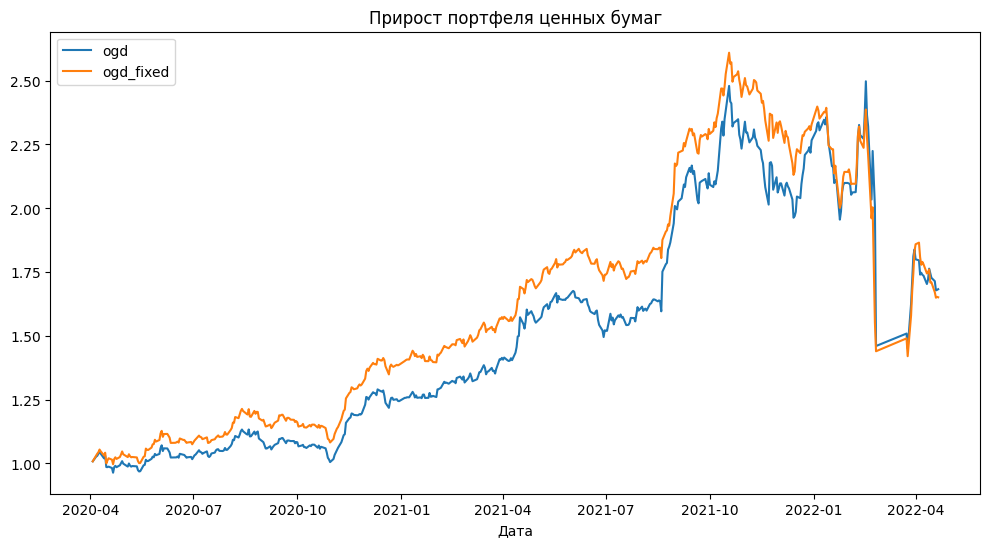

In [144]:
profit_data = pd.DataFrame(index = returns.index[1:], data = profit)
profit_data_fixed = pd.DataFrame(index = returns.index[1:], data = profit_fixed)

plt.figure(figsize=(12,6))
plt.plot(profit_data, label = "ogd")
plt.plot(profit_data_fixed, label = "ogd_fixed")
plt.title('Прирост портфеля ценных бумаг')
plt.xlabel('Дата')
plt.legend()
plt.show()

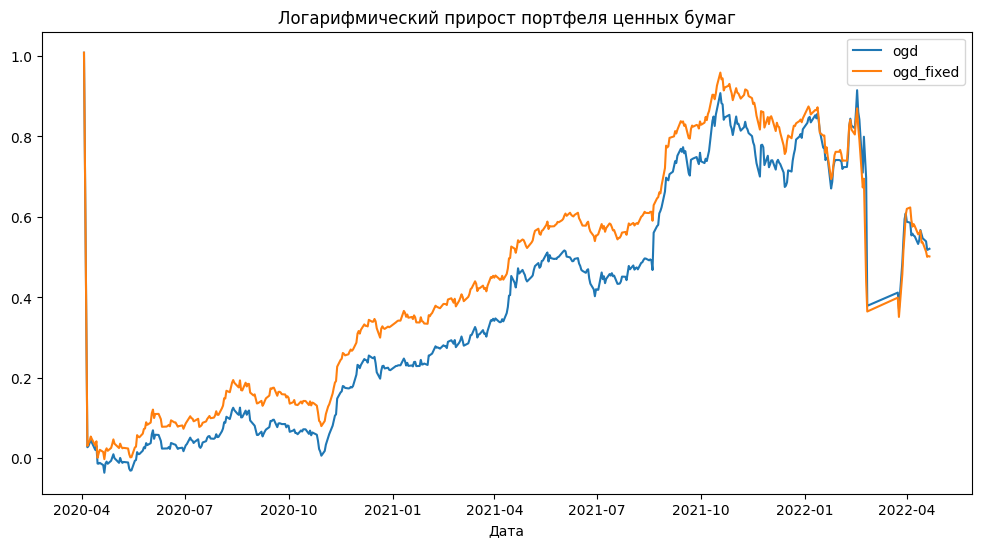

In [145]:
profit_data = pd.DataFrame(index = returns.index[1:], data = get_log_profit(profit))
profit_data_fixed = pd.DataFrame(index = returns.index[1:], data = get_log_profit(profit_fixed))

plt.figure(figsize=(12,6))
plt.plot(profit_data, label = "ogd")
plt.plot(profit_data_fixed, label = "ogd_fixed")
plt.title('Логарифмический прирост портфеля ценных бумаг')
plt.xlabel('Дата')
plt.legend()
plt.show()

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

# Стохастический градиентный спуск SGD
Метод стахастического градиент (SGD, stochastic gradient descent) устроен следующим образом:
* Задается начальное приближение $x_1 \in D$, а также постедовательность шагов ${a_t}$.
* Для каждого раунда $t \in [1, T]$ итеративно выполняются следующие шаги:
    - наблюдется случайный вектор $\nabla (x_t)$ и по определению $f_t(x) = <∇(x_t), x>$
    - осуществляется сдвиг и проектирование в соответствии с OGD: \
    $$y_{t+1} = x_t - \alpha_t ∇f_t(x_t)$$
    $$x_{t+1} = П_D(y_t + 1)$$
* В качестве приближенного решения задачи возвращается среднее значение от всех предсказаний:\
$$x_T = \frac{1}{T} \sum_{t=1}^{T} x_t$$

In [146]:
from typing import List
import numpy as np
import random as rand

def stochastic_investor(x, r, eta):
    grad = -r / np.dot(r.reshape(1,6), x.T)
    x = simplex_projection(x - eta * grad)
    return x, grad

def stochastic_gradient_descent(r, alpha: float) -> Tuple[np.ndarray, List[np.ndarray]]:
    d = len(r[0])
    T = len(r)
    x = np.ones(d) / d  # начальное распределение равномерное
    res = [x]
    x_res = x
    for t in range(1, T):
        eta = alpha / np.sqrt(t)
        x_new, grad = stochastic_investor(x, r[t-1], eta)
        x_res +=x_new
        num = rand.randint(0, 5)
        grad[num] = 0
        x = grad
        res.append(x_new)
    return x_res/T, res

Итоговое распределение, полученное с помощью SGD:

In [147]:
x, sgd = stochastic_gradient_descent(returns.values, 8)
x

array([0.16736668, 0.16435136, 0.1575911 , 0.1779505 , 0.15623586,
       0.17650449])

Итоговое распределение, полученное с помощью OGD:

In [148]:
ogd[-1]

array([0.08124999, 0.05040973, 0.12688903, 0.48078949, 0.25627941,
       0.00438235])

Это означает, что усреднение позволяет получить более надежную оценку, чем использование только последнего значения. При использовании только последнего значения, результат может быть сильно повлиян случайными факторами на всех итерациях. Однако, если мы будем суммировать и усреднять результаты, мы можем уменьшить влияние случайных факторов и получить более точную оценку.

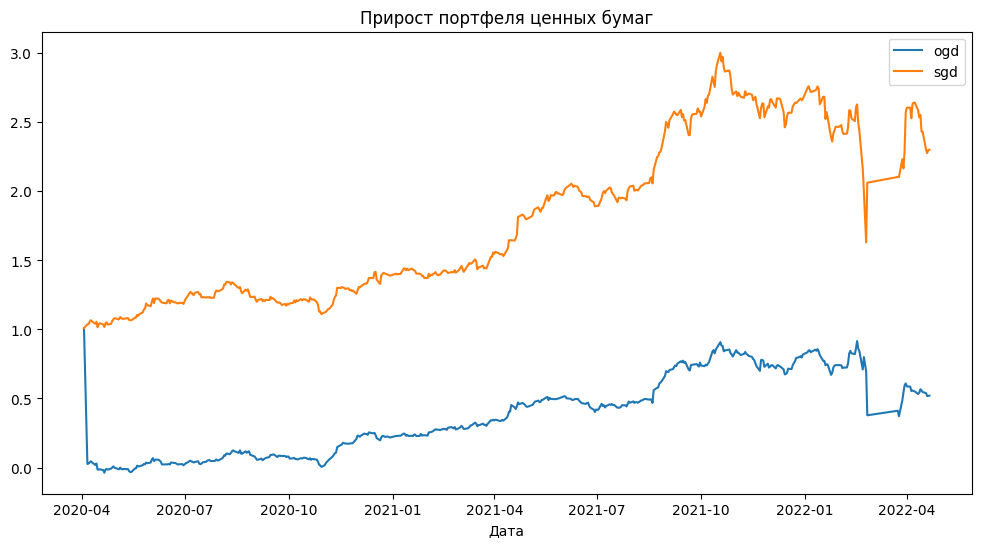

In [149]:
sgd_profit = get_profit(sgd)
sgd_profit_data = pd.DataFrame(index = returns.index[1:], data = sgd_profit)

plt.figure(figsize=(12,6))
plt.plot(profit_data, label = "ogd")
plt.plot(sgd_profit_data, label = "sgd")
plt.title('Прирост портфеля ценных бумаг')
plt.xlabel('Дата')
plt.legend()
plt.show()